In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import time
import os
import copy

import dnnlib
import legacy

torch.cuda.set_device(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


device = torch.device('cuda')
with dnnlib.util.open_url("model/ffhq.pkl") as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

device = torch.device('cuda')
with dnnlib.util.open_url("model/ffhq.pkl") as f:
    G_style = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

In [4]:
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
ws = G.mapping(z,0.7)


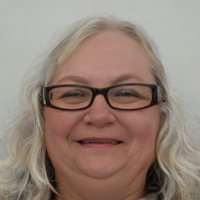

In [5]:
# z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
# ws = G.mapping(z,0,truncation_psi=0.7)
img = G.synthesis(ws, noise_mode='random')
# img = G(z, 2, truncation_psi=0.7, noise_mode='random')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
ori_im = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))
ori_im

In [6]:
total_grad = []
def backward_hook(module,grad_in,grad_out):
    total_grad.append(grad_out[0][0])
    
back_handle = []
for block_name in G.synthesis._modules:
    for layer_name in G.synthesis._modules[block_name]._modules:
        cur_handle = G.synthesis._modules[block_name]._modules[layer_name].affine.register_backward_hook(backward_hook)
        back_handle.append(cur_handle)    
#         break
#     break
print(len(back_handle))

26


In [34]:
for h in back_handle:
    h.remove()

In [8]:
from torch.autograd.gradcheck import get_analytical_jacobian,_iter_tensors,_compute_analytical_jacobian_rows,_stack_and_check_tensors
import time
def get_analytical_jacobian(inputs, output):
    diff_input_list = list(_iter_tensors(inputs, True))

    def vjp_fn(grad_output):
        return torch.autograd.grad(output, diff_input_list, grad_output,
                                   retain_graph=True, allow_unused=True)
    # Compute everything twice to check for nondeterminism (which we call reentrancy)
    vjps1 = _compute_analytical_jacobian_rows(vjp_fn, output.clone())

    output_numel = output.numel()
    jacobians1, _, _ = _stack_and_check_tensors(vjps1, inputs, output_numel)
    return jacobians1

start_time = time.time()

ws.requires_grad_(True)
total_grad = []

avgpool = nn.AvgPool2d((32, 32), stride=(32, 32))
output = G.synthesis(ws, noise_mode='const')
output_resize = avgpool(output)

res = get_analytical_jacobian(ws,output_resize[:,0,:,:])
grad = np.array((total_grad)) # 26 layers * 1024 position # channel

print("total_cost:",time.time() - start_time)
print("total_output_size:", len(total_grad) / len(back_handle),len(back_handle))
# grad = res[0][0][1]
# grad = grad.detach().cpu().numpy()
# Image.fromarray(np.uint8(np.where(grad.reshape(32,32) > 0,0,255))).resize((200,200))

/root/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/root/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/root/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when

total_cost: 24.23016667366028
total_output_size: 1024.0 26


In [122]:
mask_im = Image.open("data/mask.png").convert("L")
mask_arr = np.array(mask_im.resize((32,32)))

In [151]:
index = 3
channel = 169
hold = 180

res_dict = {}
cnt = 0
for i in range(26):
    for j in range(len(grad[25-i])):
        index = i
        channel = j
        
        gradient_map = np.array([grad[26*i + 25 - index][channel].detach().cpu().numpy() for i in range(1024)])
        gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
        gradient_binary_map = np.uint8(np.where(gradient_heat_map > hold ,255,0))
        # gradient_binary_map = np.uint8(np.where(gradient_heat_map > hold ,gradient_heat_map,0))

        gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
        # gradient_im = Image.fromarray(gradient_heat_map).resize((200,200))

        # Image.blend(gradient_im,mask_im,0.5)
        # Image.fromarray(gradient_binary_map).resize((200,200))
#         Image.fromarray(np.uint8(np.where(gradient_binary_map > 0,mask_arr,0)))

        cover_num = np.sum(np.where(np.where(gradient_binary_map > 0,mask_arr,0)>0,1,0))
        real_num = np.sum(np.where(mask_arr>0,1,0))
        predict_num = np.sum(np.where(gradient_binary_map>0,1,0))
        precision = cover_num / predict_num
        recall = cover_num / real_num
        res_dict[(i,j)] = (recall,precision,i,j)
        
        cnt += 1
        if cnt % 1000 == 0:
            print(cnt)

1000
2000
3000
4000
5000
6000
7000
8000
9000


In [491]:
sorted_res = sorted(res_dict.values(),key=lambda x:(-x[0],-x[1]))
# for k in res_dict:
#     v = res_dict[k]
#     res_dict[k] = (v[0],v[1],k[0],k[1])

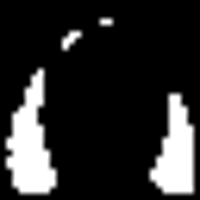

In [168]:
index = 10
channel = 125
hold = 180

gradient_map = np.array([grad[26*i + 25 - index][channel].detach().cpu().numpy() for i in range(1024)])
gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
gradient_binary_map = np.uint8(np.where(gradient_heat_map > hold ,255,0))
# gradient_binary_map = np.uint8(np.where(gradient_heat_map > hold ,gradient_heat_map,0))

gradient_im = Image.fromarray(gradient_binary_map).resize((200,200))
# gradient_im = Image.fromarray(gradient_heat_map).resize((200,200))

# Image.blend(gradient_im,mask_im,0.5)
gradient_im
# Image.fromarray(gradient_binary_map).resize((200,200))
#         Image.fromarray(np.uint8(np.where(gradient_binary_map > 0,mask_arr,0)))


# 前向测试

In [493]:
index_dict = {
    '0':'b4_conv1',
    '1':'b4_torgb',
    '2':"b8_conv0",
    '3':'b8_conv1',
    '4':'b8_torgb',
    '5':'b16_conv0',
    '6':'b16_conv1',
    '7':'b16_torgb',
    '8':'b32_conv0',
    '9':'b32_conv1',
    '10':'b32_torgb',
    '11':'b64_conv0',
    '12':'b64_conv1',
    '13':'b64_torgb',
    '14':'b128_conv0',
    '15':'b128_conv1',
    '16':'b128_torgb',
    '17':'b256_conv0',
    '18':'b256_conv1',
    '19':'b256_torgb',
    '20':'b512_conv0',
    '21':'b512_conv1',
    '22':'b512_torgb',
    '23':'b1024_conv0',
    '24':'b1024_conv1',
    '25':'b1024_torgb'
}

reverse_index_dict = {index_dict[i]:i for i in index_dict}

change_dict = {
#     "3":[(168,+100),(379,+0)],
    "3":[(378,-20)],
#     "6":[(202,0),(259,-0),(10,+50)],
#     "9":[(340,10)],
#     "12":[(330,-10)],
}


# def foward_hook(module,input,output):
#     print(cur_index,cur_channel,cur_num)
#     output[0,cur_channel] += cur_num
#     return output

def forward_hook_wrap(cur_index,cur_channel,cur_num,debug=True):
    def forward_hook(module,input,output):
        if debug:
            print(cur_index,cur_channel,cur_num,output[0,cur_channel])
#         print(output[0,cur_channel])
        output[0,cur_channel] += cur_num
#         r =  random.random() 
    
#         output[0,cur_channel] = output[0,cur_channel] * 0.5 + random.random() * 0.5
#         print(r)
        return output
    return forward_hook
    
# 清除当前style
if "handle" in locals():
    for h in handle:
        h.remove()
handle = []

# for block_name in G_style.synthesis._modules:
#     for layer_name in G_style.synthesis._modules[block_name]._modules:
#         affine_name = block_name + "_" + layer_name
#         if affine_name in reverse_index_dict and  reverse_index_dict[affine_name] in change_dict:
#             change_list = change_dict[reverse_index_dict[affine_name]]
#             for c,n in change_list:
#                 cur_index = reverse_index_dict[affine_name]
#                 cur_channel = c
#                 cur_num = n
#                 cur_handle = G_style.synthesis._modules[block_name]._modules[layer_name].affine.register_forward_hook(forward_hook_wrap(cur_index,cur_channel,cur_num))
#                 handle.append(cur_handle)  



def generate_wrap(G,change_dict,debug=True):
    global handle
    if "handle" in locals() or "handle" in globals():
#         print("remove handle")
        for h in handle:
            h.remove()
    handle = []

    for block_name in G_style.synthesis._modules:
        for layer_name in G_style.synthesis._modules[block_name]._modules:
            affine_name = block_name + "_" + layer_name
            if affine_name in reverse_index_dict and  reverse_index_dict[affine_name] in change_dict:
                change_list = change_dict[reverse_index_dict[affine_name]]
                for c,n in change_list:
                    cur_index = reverse_index_dict[affine_name]
                    cur_channel = c
                    cur_num = n
                    cur_handle = G_style.synthesis._modules[block_name]._modules[layer_name].affine.register_forward_hook(forward_hook_wrap(cur_index,cur_channel,cur_num,debug))
                    handle.append(cur_handle)     

G

style
3 169 5 tensor(-1.4019, device='cuda:1', grad_fn=<SelectBackward>)
over


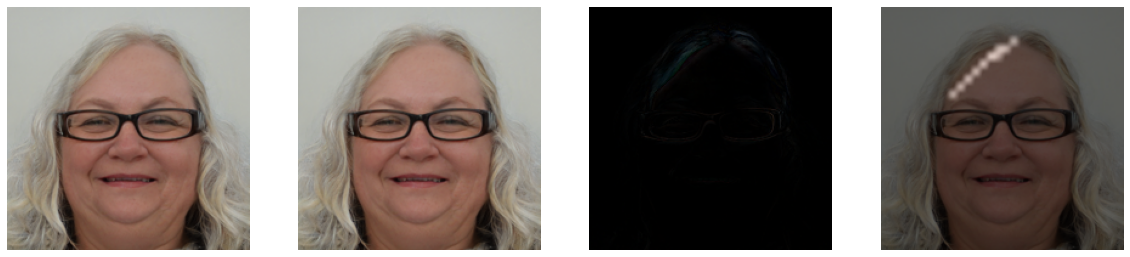

In [528]:
# z = torch.from_numpy(np.random.randn(1, G.z_dim)).to('cuda')
# ws = G.mapping(z,0.7)

# v1 = np.load("out/projected_w_yoycol_1.npz")['w']
# ws = torch.Tensor(v1).cuda()

# best_index = 2176
recall,precision,index,channel = sorted_res[best_index]
channel = 169
#         print(recall,precision,index,channel )
cur_change_dict = {"3":[(channel,+5)]}

# cur_change_dict = {"3":[(62,100)]}
# cur_change_dict = {str(i):[] for i in range(26)}
# for i,j in enumerate(sorted_res):
#     if j[2]  % 3 ==  0  :
#         recall,precision,index,channel = sorted_res[i]
# #         print(recall,precision,index,channel )
#         cur_change_dict[str(j[2])].append((channel,100))
# #     cur_change_dict = {"3":[[i,+10] for i in range(500) if random.random() < 0.01]}
generate_wrap(G_style,cur_change_dict,debug=True)

print('G'+"\n")
img = G.synthesis(ws, noise_mode='const')
# img = G(z, 2, truncation_psi=0.7, noise_mode='const')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
im1 = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))

print("style")
img = G_style.synthesis(ws, noise_mode='const')
# img = G_style(z, 2, truncation_psi=0.7, noise_mode='const')
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
im2 = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').resize((200,200))
print("over")

%matplotlib inline
import  matplotlib.pyplot as plt
from PIL import Image
plt.figure(figsize=(20,15))

plt.subplot(1,4,1)
plt.axis("off")
plt.imshow(im1)

plt.subplot(1,4,2)
plt.axis("off")
plt.imshow(im2)


im_diff = Image.fromarray(np.uint8(np.abs(np.float32(np.array(im2)) - np.float32(np.array(im1)))))
plt.subplot(1,4,3)
plt.axis("off")
plt.imshow(im_diff)


gradient_map = np.array([grad[26*i + 25 - index][channel].detach().cpu().numpy() for i in range(1024)])
gradient_heat_map = np.uint8((gradient_map - np.min(gradient_map)) / (np.max(gradient_map) - np.min(gradient_map)) * 255).reshape(32,32)
gradient_binary_map = np.uint8(np.where(gradient_heat_map > 180 ,gradient_heat_map,0))
# gradient_binary_map = np.uint8(np.where(gradient_heat_map > hold ,gradient_heat_map,0))

gradient_im = Image.fromarray(gradient_binary_map).resize((200,200)).convert("RGB")
blend_im = Image.blend(gradient_im,im2,0.5)

plt.subplot(1,4,4)
plt.axis("off")
plt.imshow(blend_im)

In [492]:
c = 0
for i,j in enumerate(sorted_res):
    if j[2]  == 3:
        print(c,i,j)
        c += 1

0 316 (0.9436893203883495, 0.48893360160965793, 3, 62)
1 385 (0.9242718446601942, 0.4887063655030801, 3, 155)
2 488 (0.8970873786407767, 0.48125, 3, 435)
3 490 (0.8970873786407767, 0.47875647668393784, 3, 10)
4 579 (0.8660194174757282, 0.4821621621621622, 3, 340)
5 635 (0.8504854368932039, 0.4689507494646681, 3, 436)
6 641 (0.8485436893203884, 0.4648936170212766, 3, 50)
7 663 (0.8427184466019417, 0.46918918918918917, 3, 29)
8 690 (0.8330097087378641, 0.46178686759956944, 3, 347)
9 721 (0.8233009708737864, 0.4623773173391494, 3, 352)
10 799 (0.7941747572815534, 0.4605855855855856, 3, 164)
11 818 (0.7844660194174757, 0.4622425629290618, 3, 473)
12 876 (0.7631067961165049, 0.4734939759036145, 3, 341)
13 893 (0.7572815533980582, 0.44368600682593856, 3, 69)
14 898 (0.7553398058252427, 0.443557582668187, 3, 5)
15 908 (0.7514563106796116, 0.4974293059125964, 3, 428)
16 914 (0.7514563106796116, 0.4407744874715262, 3, 474)
17 1053 (0.6932038834951456, 0.4219858156028369, 3, 267)
18 1264 (0.5980

In [488]:
len(cur_change_dict['0'])

512

In [489]:
cur_change_dict

{'0': [(348, 100),
  (270, 100),
  (240, 100),
  (132, 100),
  (367, 100),
  (297, 100),
  (300, 100),
  (337, 100),
  (154, 100),
  (186, 100),
  (321, 100),
  (330, 100),
  (30, 100),
  (382, 100),
  (37, 100),
  (94, 100),
  (213, 100),
  (359, 100),
  (453, 100),
  (137, 100),
  (174, 100),
  (214, 100),
  (227, 100),
  (393, 100),
  (465, 100),
  (488, 100),
  (1, 100),
  (61, 100),
  (96, 100),
  (179, 100),
  (191, 100),
  (197, 100),
  (247, 100),
  (261, 100),
  (445, 100),
  (509, 100),
  (9, 100),
  (245, 100),
  (315, 100),
  (319, 100),
  (405, 100),
  (175, 100),
  (378, 100),
  (406, 100),
  (482, 100),
  (497, 100),
  (32, 100),
  (79, 100),
  (116, 100),
  (282, 100),
  (413, 100),
  (436, 100),
  (484, 100),
  (510, 100),
  (6, 100),
  (44, 100),
  (88, 100),
  (112, 100),
  (332, 100),
  (362, 100),
  (366, 100),
  (417, 100),
  (438, 100),
  (451, 100),
  (89, 100),
  (152, 100),
  (182, 100),
  (290, 100),
  (327, 100),
  (389, 100),
  (420, 100),
  (471, 100),
  (